In [1]:
import numpy as np
import pandas as pd
import sklearn, sklearn.preprocessing, sklearn.model_selection, sklearn.linear_model, sklearn.metrics, sklearn.feature_selection, sklearn.ensemble
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Numbers display set-up
pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# 1) Data Preparation

We are going to use following dataset to train a model for predicting a yearly salary (total compensation) when we are hiring a new employee. This model can help to HR department. Credit to Worksday's tutorial on ML Prague.

In [2]:
df = pd.read_csv('hr-data.csv')
df.shape

(5000, 24)

In [3]:
df.head(3)

,compa_ratio,compa_ratio_range,cost_center,country,current_rating,ethnicity,gender,generation,high_performer,high_potential,hiring_source,is_leader,is_manager,job_family_group,job_level,job_profile,length_of_service,location,management_level,region,single_job_family,tenure_category,total_compensation,age
0,1.545,Above Compa-Ratio,AMER - United States of America,United States of America,4 - Exceeds Expectations,Asian,Female,Generation X (1965-1980),False,False,Referral,True,True,Executive,M9,Executive Management - Chief Executive Officer,26.934,San Francisco,Chief Executive Officer,AMER,Executive Management,15+ Years,772400,57.000
1,1.021,At Compa-Ratio,AMER - United States of America,United States of America,3 - Meets Expectations,White,Male,Generation Z (1997 and onwards),False,True,Referral,False,False,Development,P2,IT - Product Development - P2 Business Analytics,1.844,New York,Individual Contributor,AMER,IT - Product Development,01-02 Years,68900,25.000
2,0.981,At Compa-Ratio,Global Support - Asia/Pac,South Korea,5 - Outstanding Performance,Asian,Male,Generation Y/Millenials (1981-1996),True,False,Recruiter,False,False,Development,P3,IT - Product Development - P3 Data Scientist,2.192,Seoul,Individual Contributor,APAC,IT - Product Development,02-05 Years,53200,33.000


In [4]:
df.describe(include="all")

,compa_ratio,compa_ratio_range,cost_center,country,current_rating,ethnicity,gender,generation,high_performer,high_potential,hiring_source,is_leader,is_manager,job_family_group,job_level,job_profile,length_of_service,location,management_level,region,single_job_family,tenure_category,total_compensation,age
count,5000.000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000.000,5000,5000,5000,5000,5000,5000.000,5000.000
unique,NaN,3,5,6,5,5,2,4,2,2,6,2,2,5,13,90,NaN,19,6,3,11,6,NaN,NaN
top,NaN,Above Compa-Ratio,AMER - United States of America,United States of America,4 - Exceeds Expectations,White,Female,Generation Y/Millenials (1981-1996),False,False,Referral,False,False,Development,P4,Board Management - Senior Board Associate,NaN,San Francisco,Individual Contributor,AMER,IT - Product Development,05-10 Years,NaN,NaN
freq,NaN,3284,1275,1275,1013,2282,2500,3364,3992,4227,1531,4674,4409,1476,1334,242,NaN,876,3913,2515,1309,1359,NaN,NaN
mean,1.169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.997,NaN,NaN,NaN,NaN,NaN,131567.360,36.859
std,0.227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.745,NaN,NaN,NaN,NaN,NaN,107949.422,10.741
min,0.639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003,NaN,NaN,NaN,NaN,NaN,24600.000,21.000
25%,0.990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.595,NaN,NaN,NaN,NaN,NaN,67500.000,29.000
50%,1.173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.699,NaN,NaN,NaN,NaN,NaN,104300.000,34.000
75%,1.352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.648,NaN,NaN,NaN,NaN,NaN,152700.000,40.000


In [5]:
df.tenure_category.value_counts().index

Index(['05-10 Years', '02-05 Years', '10-15 Years', '15+ Years', '00-01 Years',
       '01-02 Years'],
      dtype='object', name='tenure_category')

In [6]:
df.replace(np.nan, "nan", regex=True, inplace=True)
categorical_columns = df.select_dtypes(include=["object"]).columns
categorical_columns

Index(['compa_ratio_range', 'cost_center', 'country', 'current_rating',
       'ethnicity', 'gender', 'generation', 'hiring_source',
       'job_family_group', 'job_level', 'job_profile', 'location',
       'management_level', 'region', 'single_job_family', 'tenure_category'],
      dtype='object')

In [7]:
ordinal_columns_category_order_dict = {
    'compa_ratio_range': ['Below Compa-Ratio', 'At Compa-Ratio', 'Above Compa-Ratio'],
    'current_rating': ['1 - Unsatisfactory', '2 - Needs Improvement', '3 - Meets Expectations', '4 - Exceeds Expectations', '5 - Outstanding Performance'],
    'tenure_category': ['00-01 Years', '01-02 Years', '02-05 Years', '05-10 Years', '10-15 Years', '15+ Years']
}

In [8]:
df_encoded = df.select_dtypes(exclude=["object"]).copy()
for col in ['high_performer', 'high_potential', 'is_leader', 'is_manager']:
    df_encoded[col] = df_encoded[col].astype(int)
df_encoded.head()

,compa_ratio,high_performer,high_potential,is_leader,is_manager,length_of_service,total_compensation,age
0,1.545,0,0,1,1,26.934,772400,57.000
1,1.021,0,1,0,0,1.844,68900,25.000
2,0.981,1,0,0,0,2.192,53200,33.000
3,1.342,0,1,0,0,18.518,204600,45.000
4,1.290,0,0,0,0,1.416,70000,32.000


In [9]:
ordinal_encoder = sklearn.preprocessing.OrdinalEncoder(categories=[ordinal_columns_category_order_dict[column] for column in ordinal_columns_category_order_dict.keys()])
df_encoded = df_encoded.join(pd.DataFrame(ordinal_encoder.fit_transform(df[ordinal_columns_category_order_dict.keys()]), index=df.index, columns=ordinal_columns_category_order_dict.keys()))
df_encoded.head()

,compa_ratio,high_performer,high_potential,is_leader,is_manager,length_of_service,total_compensation,age,compa_ratio_range,current_rating,tenure_category
0,1.545,0,0,1,1,26.934,772400,57.000,2.000,3.000,5.000
1,1.021,0,1,0,0,1.844,68900,25.000,1.000,2.000,1.000
2,0.981,1,0,0,0,2.192,53200,33.000,1.000,4.000,2.000
3,1.342,0,1,0,0,18.518,204600,45.000,2.000,1.000,5.000
4,1.290,0,0,0,0,1.416,70000,32.000,2.000,2.000,1.000


In [10]:
nominal_columns = [column for column in categorical_columns if column not in ordinal_columns_category_order_dict.keys()]
df_encoded = df_encoded.join(pd.get_dummies(df[nominal_columns], prefix_sep="="))
df_encoded.head()

,compa_ratio,high_performer,high_potential,is_leader,is_manager,length_of_service,total_compensation,age,compa_ratio_range,current_rating,tenure_category,cost_center=AMER - Canada,cost_center=AMER - United States of America,cost_center=EMEA - France,cost_center=EMEA - United Kingdom,cost_center=Global Support - Asia/Pac,country=Canada,country=France,country=Singapore,country=South Korea,country=United Kingdom,country=United States of America,ethnicity=American Indian or Alaska Native,ethnicity=Asian,ethnicity=Black or African American,ethnicity=Hispanic,ethnicity=White,gender=Female,gender=Male,generation=Baby Boomers (1946-1964),generation=Generation X (1965-1980),generation=Generation Y/Millenials (1981-1996),generation=Generation Z (1997 and onwards),hiring_source=Agency,hiring_source=Corporate Website,hiring_source=Internal,hiring_source=Linkedin,hiring_source=Recruiter,hiring_source=Referral,job_family_group=Development,job_family_group=Executive,job_family_group=Finance,job_family_group=Sales,job_family_group=Services,job_level=M2,job_level=M3,job_level=M4,job_level=M5,job_level=M6,job_level=M7,job_level=M8,job_level=M9,job_level=P1,job_level=P2,job_level=P3,job_level=P4,job_level=P5,job_profile=Board Management - Executive Vice President,job_profile=Board Management - Principal Board Associate,job_profile=Board Management - Senior Board Associate,job_profile=Board Management - Vice President,job_profile=Executive Management - Chief Executive Officer,job_profile=Executive Management - Executive Vice President,job_profile=Executive Management - Principal Operations Executive,job_profile=Executive Management - Senior Operations Executive,job_profile=Executive Management - Vice President,job_profile=FA - Accounting - P2 Accounting Settlement Specialist,job_profile=FA - Accounting - P2 Finance Analyst,job_profile=FA - Accounting - P3 Accounting Settlement Specialist,job_profile=FA - Accounting - P3 Finance Analyst,job_profile=FA - Accounting - Principal Accounting Settlement Specialist,job_profile=FA - Accounting - Principal Finance Analyst,job_profile=FA - Accounting - Senior Accounting Settlement Specialist,job_profile=FA - Accounting - Senior Finance Analyst,job_profile=FA - Management - Associate Manager,job_profile=FA - Management - Director,job_profile=FA - Management - Manager,job_profile=FA - Management - Senior Director,job_profile=FA - Management - Senior Manager,job_profile=Human Resources - Associate Manager,job_profile=Human Resources - Director,job_profile=Human Resources - Manager,job_profile=Human Resources - P2 Human Resources Analyst,job_profile=Human Resources - P2 Human Resources Consultant,job_profile=Human Resources - P3 Human Resources Analyst,job_profile=Human Resources - P3 Human Resources Consultant,job_profile=Human Resources - Principal Human Resources Analyst,job_profile=Human Resources - Principal Human Resources Consultant,job_profile=Human Resources - Senior Director,job_profile=Human Resources - Senior Human Resources Analyst,job_profile=Human Resources - Senior Human Resources Consultant,job_profile=Human Resources - Senior Manager,job_profile=Human Resources - Vice President,job_profile=IT - Product Development - P1 Business Analytics,job_profile=IT - Product Development - P1 Data Scientist,job_profile=IT - Product Development - P1 QA,job_profile=IT - Product Development - P1 Software Engineer,job_profile=IT - Product Development - P2 Business Analytics,job_profile=IT - Product Development - P2 Data Scientist,job_profile=IT - Product Development - P2 QA,job_profile=IT - Product Development - P2 Software Engineer,job_profile=IT - Product Development - P3 Business Analytics,job_profile=IT - Product Development - P3 Data Scientist,job_profile=IT - Product Development - P3 QA,job_profile=IT - Product Development - P3 Software Engineer,job_profile=IT - Product Development - Principal Business Analytics,job_profile=IT - Product Development - Principal Data Scientist,job_profile=IT - Product Devel

In [11]:
df_encoded.shape

(5000, 186)

# 2) Linear Regression

There are a few assumptions associated with a linear regression model:

* Linearity: The relationship between X and Y is linear.
* Homoscedasticity: The variance of residual is the same for any value of X.
* No multicollinearity: There is no high correlations among two or more independent variables.
* Independence: Observations are independent of each other.
* Normality: For any fixed value of X, Y is normally distributed.

In [12]:
X_data = df_encoded.drop('total_compensation', axis=1)
y_data = df_encoded['total_compensation']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_data, y_data, test_size=0.20, random_state=12
)
column_names = X_train.columns

In [13]:
scaler = sklearn.preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
model = sklearn.linear_model.LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
residuals = y_test - y_pred

# Evaluate the model
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared=False)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Percentage Error (MAPE): 623157150.0683959
Root Mean Squared Error: 1.522088299520573e+16
R-squared: -2.1784765862073634e+22


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [15]:
residuals.describe()

,total_compensation
count,1000.000
mean,481326582637491.438
std,15220882995205606.000
min,-118468.181
25%,-6277.181
50%,-778.931
75%,6551.319
max,481326582637758528.000


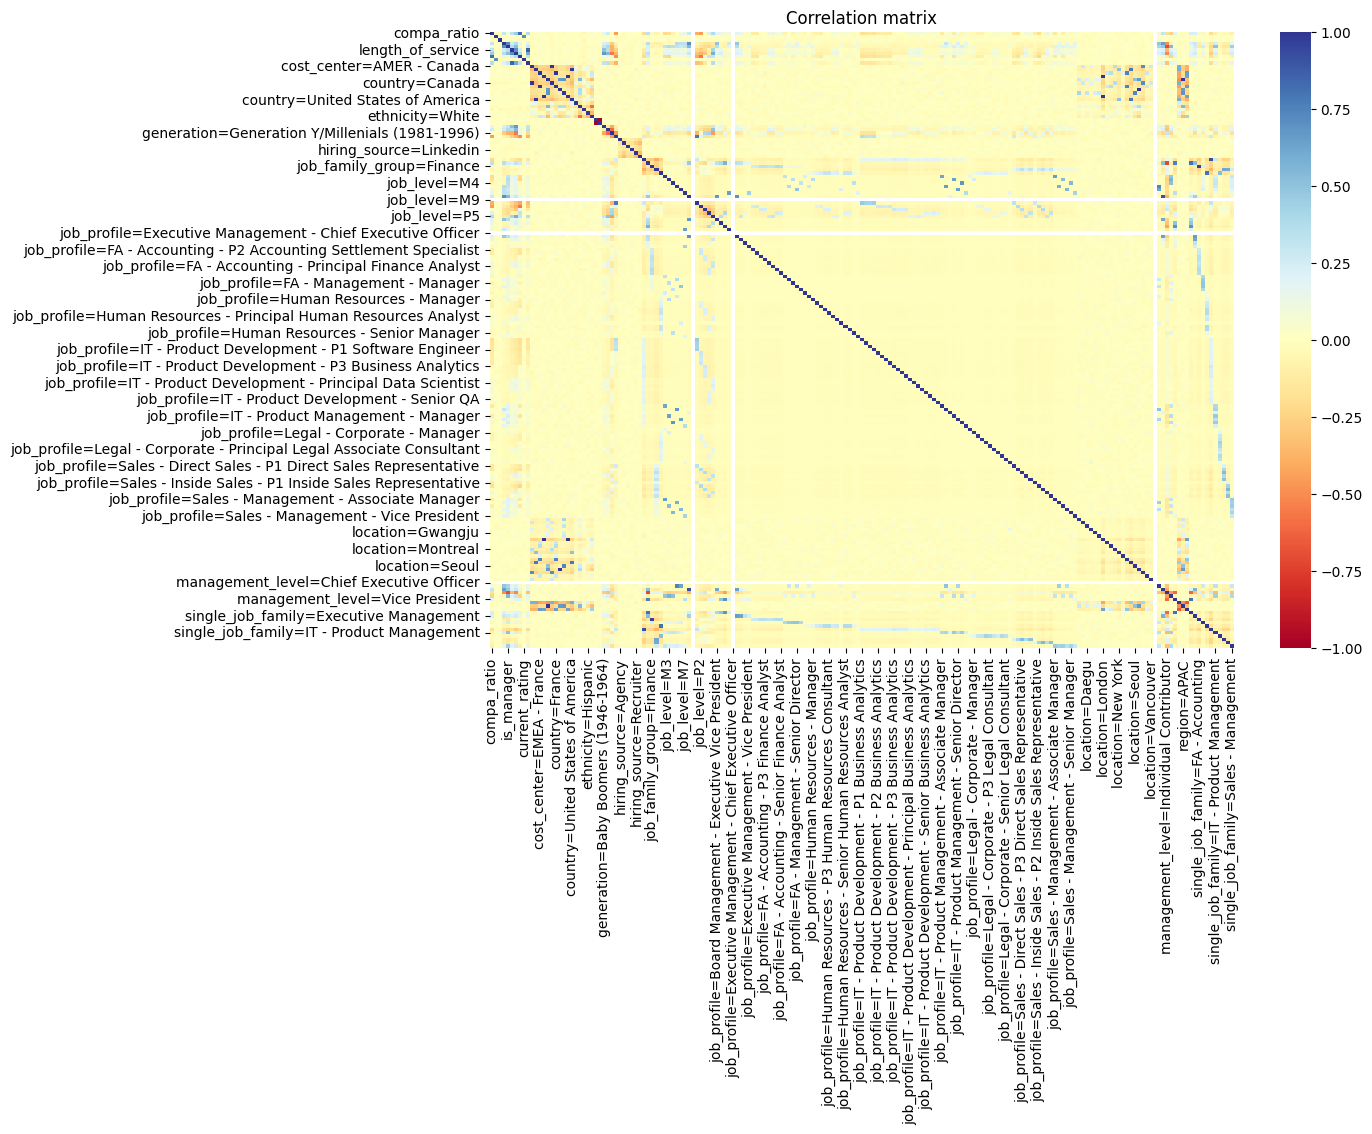

In [16]:
# We broke multicollinearity assumption by using all features
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr(), annot=False, cmap='RdYlBu', vmin=-1, vmax=1)
plt.title('Correlation matrix')
plt.show()
# NOTE: White line represents columns which contain only zeros

# 3) Orthogonal Matching Pursuit

In [17]:
n_coefs = 11
model = sklearn.linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=n_coefs)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
residuals = y_test - y_pred

# Evaluate the model
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared=False)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Percentage Error (MAPE): 0.12508973808636517
Root Mean Squared Error: 25115.23968820704
R-squared: 0.9406872778959966


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


What are the residuals?

In [18]:
residuals.describe()

,total_compensation
count,1000.000
mean,-71.508
std,25127.705
min,-136974.590
25%,-9392.462
50%,-2249.060
75%,6910.988
max,465699.425


How does the target attribute looks like?

<Axes: >

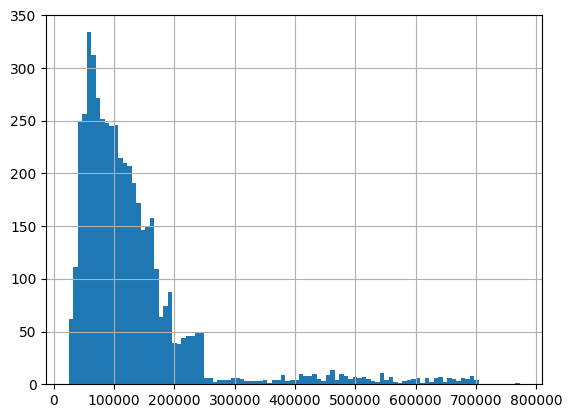

In [19]:
df['total_compensation'].hist(bins=100)

What is the model doing? There is a linear model inside :-).

In [20]:
y_pred = X_test_scaled @ model.coef_ + model.intercept_
y_pred[:5]

array([40012.98749039, 72509.05456051, 26720.48469275, 74277.72802948,
       43852.45827751])

### Use coefficients estimated by OMP to visualize their impact using (e.g.: seaborn, matplotlib). Think about the interpretation of the visualization, especially "age", "job_level -> M8" and "generation -> Baby Boomers (1946 - 1964)".

In [21]:
n_coefs = 11
model = sklearn.linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=n_coefs)
model.fit(X_train_scaled, y_train)

OrthogonalMatchingPursuit(n_nonzero_coefs=11)

<ipython-input-22-93e18c6e9f43>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=selected_features, y=selected_features.index, palette=colors, dodge=False)
<ipython-input-22-93e18c6e9f43>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_features.index)


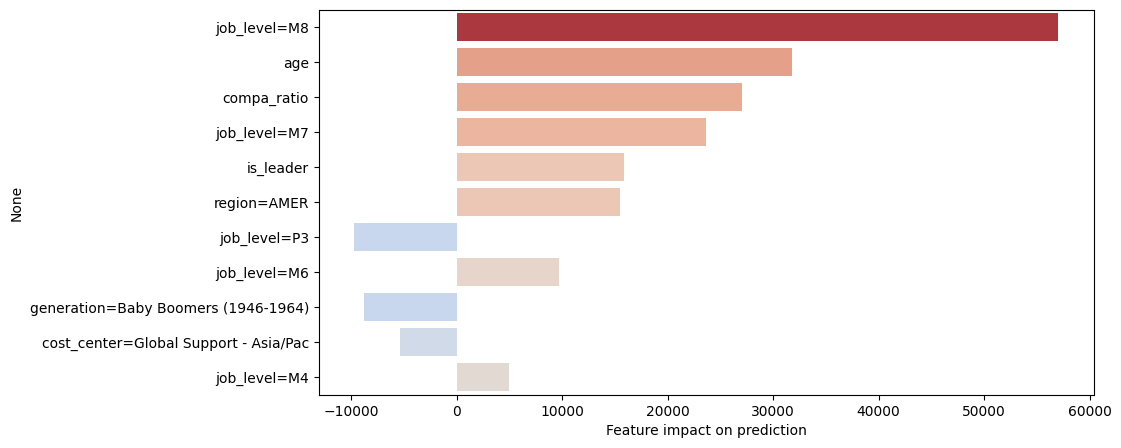

In [22]:
# Visualise the features that have been selected and their respective scores
feature_scores = pd.Series(model.coef_, index=X_data.columns).sort_values(ascending=False, key=lambda x: abs(x))
selected_features = feature_scores[:n_coefs]

f, ax = plt.subplots(figsize=(10, 5))
shades = 31
palette = sns.color_palette('coolwarm', shades)
minmax = np.max([-np.min(selected_features), np.max(selected_features)])
bins = np.linspace(-minmax, minmax, num=shades)
palette_indices = np.digitize(selected_features, bins) - 1
colors = [palette[idx] for idx in palette_indices]

ax = sns.barplot(x=selected_features, y=selected_features.index, palette=colors, dodge=False)
ax.set_yticklabels(selected_features.index)
ax.set_xlabel('Feature impact on prediction')
plt.show()

#### What you can tell about these features?

#### Lets see what a one year change in age can do

In [23]:
X_test.iloc[0:1]

,compa_ratio,high_performer,high_potential,is_leader,is_manager,length_of_service,age,compa_ratio_range,current_rating,tenure_category,cost_center=AMER - Canada,cost_center=AMER - United States of America,cost_center=EMEA - France,cost_center=EMEA - United Kingdom,cost_center=Global Support - Asia/Pac,country=Canada,country=France,country=Singapore,country=South Korea,country=United Kingdom,country=United States of America,ethnicity=American Indian or Alaska Native,ethnicity=Asian,ethnicity=Black or African American,ethnicity=Hispanic,ethnicity=White,gender=Female,gender=Male,generation=Baby Boomers (1946-1964),generation=Generation X (1965-1980),generation=Generation Y/Millenials (1981-1996),generation=Generation Z (1997 and onwards),hiring_source=Agency,hiring_source=Corporate Website,hiring_source=Internal,hiring_source=Linkedin,hiring_source=Recruiter,hiring_source=Referral,job_family_group=Development,job_family_group=Executive,job_family_group=Finance,job_family_group=Sales,job_family_group=Services,job_level=M2,job_level=M3,job_level=M4,job_level=M5,job_level=M6,job_level=M7,job_level=M8,job_level=M9,job_level=P1,job_level=P2,job_level=P3,job_level=P4,job_level=P5,job_profile=Board Management - Executive Vice President,job_profile=Board Management - Principal Board Associate,job_profile=Board Management - Senior Board Associate,job_profile=Board Management - Vice President,job_profile=Executive Management - Chief Executive Officer,job_profile=Executive Management - Executive Vice President,job_profile=Executive Management - Principal Operations Executive,job_profile=Executive Management - Senior Operations Executive,job_profile=Executive Management - Vice President,job_profile=FA - Accounting - P2 Accounting Settlement Specialist,job_profile=FA - Accounting - P2 Finance Analyst,job_profile=FA - Accounting - P3 Accounting Settlement Specialist,job_profile=FA - Accounting - P3 Finance Analyst,job_profile=FA - Accounting - Principal Accounting Settlement Specialist,job_profile=FA - Accounting - Principal Finance Analyst,job_profile=FA - Accounting - Senior Accounting Settlement Specialist,job_profile=FA - Accounting - Senior Finance Analyst,job_profile=FA - Management - Associate Manager,job_profile=FA - Management - Director,job_profile=FA - Management - Manager,job_profile=FA - Management - Senior Director,job_profile=FA - Management - Senior Manager,job_profile=Human Resources - Associate Manager,job_profile=Human Resources - Director,job_profile=Human Resources - Manager,job_profile=Human Resources - P2 Human Resources Analyst,job_profile=Human Resources - P2 Human Resources Consultant,job_profile=Human Resources - P3 Human Resources Analyst,job_profile=Human Resources - P3 Human Resources Consultant,job_profile=Human Resources - Principal Human Resources Analyst,job_profile=Human Resources - Principal Human Resources Consultant,job_profile=Human Resources - Senior Director,job_profile=Human Resources - Senior Human Resources Analyst,job_profile=Human Resources - Senior Human Resources Consultant,job_profile=Human Resources - Senior Manager,job_profile=Human Resources - Vice President,job_profile=IT - Product Development - P1 Business Analytics,job_profile=IT - Product Development - P1 Data Scientist,job_profile=IT - Product Development - P1 QA,job_profile=IT - Product Development - P1 Software Engineer,job_profile=IT - Product Development - P2 Business Analytics,job_profile=IT - Product Development - P2 Data Scientist,job_profile=IT - Product Development - P2 QA,job_profile=IT - Product Development - P2 Software Engineer,job_profile=IT - Product Development - P3 Business Analytics,job_profile=IT - Product Development - P3 Data Scientist,job_profile=IT - Product Development - P3 QA,job_profile=IT - Product Development - P3 Software Engineer,job_profile=IT - Product Development - Principal Business Analytics,job_profile=IT - Product Development - Principal Data Scientist,job_profile=IT - Product Development - Principal 

In [24]:
pd.DataFrame(X_test_scaled[0:1, :], columns=X_test.columns)

,compa_ratio,high_performer,high_potential,is_leader,is_manager,length_of_service,age,compa_ratio_range,current_rating,tenure_category,cost_center=AMER - Canada,cost_center=AMER - United States of America,cost_center=EMEA - France,cost_center=EMEA - United Kingdom,cost_center=Global Support - Asia/Pac,country=Canada,country=France,country=Singapore,country=South Korea,country=United Kingdom,country=United States of America,ethnicity=American Indian or Alaska Native,ethnicity=Asian,ethnicity=Black or African American,ethnicity=Hispanic,ethnicity=White,gender=Female,gender=Male,generation=Baby Boomers (1946-1964),generation=Generation X (1965-1980),generation=Generation Y/Millenials (1981-1996),generation=Generation Z (1997 and onwards),hiring_source=Agency,hiring_source=Corporate Website,hiring_source=Internal,hiring_source=Linkedin,hiring_source=Recruiter,hiring_source=Referral,job_family_group=Development,job_family_group=Executive,job_family_group=Finance,job_family_group=Sales,job_family_group=Services,job_level=M2,job_level=M3,job_level=M4,job_level=M5,job_level=M6,job_level=M7,job_level=M8,job_level=M9,job_level=P1,job_level=P2,job_level=P3,job_level=P4,job_level=P5,job_profile=Board Management - Executive Vice President,job_profile=Board Management - Principal Board Associate,job_profile=Board Management - Senior Board Associate,job_profile=Board Management - Vice President,job_profile=Executive Management - Chief Executive Officer,job_profile=Executive Management - Executive Vice President,job_profile=Executive Management - Principal Operations Executive,job_profile=Executive Management - Senior Operations Executive,job_profile=Executive Management - Vice President,job_profile=FA - Accounting - P2 Accounting Settlement Specialist,job_profile=FA - Accounting - P2 Finance Analyst,job_profile=FA - Accounting - P3 Accounting Settlement Specialist,job_profile=FA - Accounting - P3 Finance Analyst,job_profile=FA - Accounting - Principal Accounting Settlement Specialist,job_profile=FA - Accounting - Principal Finance Analyst,job_profile=FA - Accounting - Senior Accounting Settlement Specialist,job_profile=FA - Accounting - Senior Finance Analyst,job_profile=FA - Management - Associate Manager,job_profile=FA - Management - Director,job_profile=FA - Management - Manager,job_profile=FA - Management - Senior Director,job_profile=FA - Management - Senior Manager,job_profile=Human Resources - Associate Manager,job_profile=Human Resources - Director,job_profile=Human Resources - Manager,job_profile=Human Resources - P2 Human Resources Analyst,job_profile=Human Resources - P2 Human Resources Consultant,job_profile=Human Resources - P3 Human Resources Analyst,job_profile=Human Resources - P3 Human Resources Consultant,job_profile=Human Resources - Principal Human Resources Analyst,job_profile=Human Resources - Principal Human Resources Consultant,job_profile=Human Resources - Senior Director,job_profile=Human Resources - Senior Human Resources Analyst,job_profile=Human Resources - Senior Human Resources Consultant,job_profile=Human Resources - Senior Manager,job_profile=Human Resources - Vice President,job_profile=IT - Product Development - P1 Business Analytics,job_profile=IT - Product Development - P1 Data Scientist,job_profile=IT - Product Development - P1 QA,job_profile=IT - Product Development - P1 Software Engineer,job_profile=IT - Product Development - P2 Business Analytics,job_profile=IT - Product Development - P2 Data Scientist,job_profile=IT - Product Development - P2 QA,job_profile=IT - Product Development - P2 Software Engineer,job_profile=IT - Product Development - P3 Business Analytics,job_profile=IT - Product Development - P3 Data Scientist,job_profile=IT - Product Development - P3 QA,job_profile=IT - Product Development - P3 Software Engineer,job_profile=IT - Product Development - Principal Business Analytics,job_profile=IT - Product Development - Principal Data Scientist,job_profile=IT - Product Development - Principal 

In [25]:
X_new_entry = X_test.iloc[0:1].copy()
X_new_entry['age'] += 1

In [26]:
pd.DataFrame(scaler.transform(X_new_entry), columns=X_test.columns)

,compa_ratio,high_performer,high_potential,is_leader,is_manager,length_of_service,age,compa_ratio_range,current_rating,tenure_category,cost_center=AMER - Canada,cost_center=AMER - United States of America,cost_center=EMEA - France,cost_center=EMEA - United Kingdom,cost_center=Global Support - Asia/Pac,country=Canada,country=France,country=Singapore,country=South Korea,country=United Kingdom,country=United States of America,ethnicity=American Indian or Alaska Native,ethnicity=Asian,ethnicity=Black or African American,ethnicity=Hispanic,ethnicity=White,gender=Female,gender=Male,generation=Baby Boomers (1946-1964),generation=Generation X (1965-1980),generation=Generation Y/Millenials (1981-1996),generation=Generation Z (1997 and onwards),hiring_source=Agency,hiring_source=Corporate Website,hiring_source=Internal,hiring_source=Linkedin,hiring_source=Recruiter,hiring_source=Referral,job_family_group=Development,job_family_group=Executive,job_family_group=Finance,job_family_group=Sales,job_family_group=Services,job_level=M2,job_level=M3,job_level=M4,job_level=M5,job_level=M6,job_level=M7,job_level=M8,job_level=M9,job_level=P1,job_level=P2,job_level=P3,job_level=P4,job_level=P5,job_profile=Board Management - Executive Vice President,job_profile=Board Management - Principal Board Associate,job_profile=Board Management - Senior Board Associate,job_profile=Board Management - Vice President,job_profile=Executive Management - Chief Executive Officer,job_profile=Executive Management - Executive Vice President,job_profile=Executive Management - Principal Operations Executive,job_profile=Executive Management - Senior Operations Executive,job_profile=Executive Management - Vice President,job_profile=FA - Accounting - P2 Accounting Settlement Specialist,job_profile=FA - Accounting - P2 Finance Analyst,job_profile=FA - Accounting - P3 Accounting Settlement Specialist,job_profile=FA - Accounting - P3 Finance Analyst,job_profile=FA - Accounting - Principal Accounting Settlement Specialist,job_profile=FA - Accounting - Principal Finance Analyst,job_profile=FA - Accounting - Senior Accounting Settlement Specialist,job_profile=FA - Accounting - Senior Finance Analyst,job_profile=FA - Management - Associate Manager,job_profile=FA - Management - Director,job_profile=FA - Management - Manager,job_profile=FA - Management - Senior Director,job_profile=FA - Management - Senior Manager,job_profile=Human Resources - Associate Manager,job_profile=Human Resources - Director,job_profile=Human Resources - Manager,job_profile=Human Resources - P2 Human Resources Analyst,job_profile=Human Resources - P2 Human Resources Consultant,job_profile=Human Resources - P3 Human Resources Analyst,job_profile=Human Resources - P3 Human Resources Consultant,job_profile=Human Resources - Principal Human Resources Analyst,job_profile=Human Resources - Principal Human Resources Consultant,job_profile=Human Resources - Senior Director,job_profile=Human Resources - Senior Human Resources Analyst,job_profile=Human Resources - Senior Human Resources Consultant,job_profile=Human Resources - Senior Manager,job_profile=Human Resources - Vice President,job_profile=IT - Product Development - P1 Business Analytics,job_profile=IT - Product Development - P1 Data Scientist,job_profile=IT - Product Development - P1 QA,job_profile=IT - Product Development - P1 Software Engineer,job_profile=IT - Product Development - P2 Business Analytics,job_profile=IT - Product Development - P2 Data Scientist,job_profile=IT - Product Development - P2 QA,job_profile=IT - Product Development - P2 Software Engineer,job_profile=IT - Product Development - P3 Business Analytics,job_profile=IT - Product Development - P3 Data Scientist,job_profile=IT - Product Development - P3 QA,job_profile=IT - Product Development - P3 Software Engineer,job_profile=IT - Product Development - Principal Business Analytics,job_profile=IT - Product Development - Principal Data Scientist,job_profile=IT - Product Development - Principal 

In [27]:
y_test[0:1]

,total_compensation
4506,44500


In [28]:
model.predict(X_test_scaled[0:1, :])

array([40012.98749039])

In [29]:
model.predict(scaler.transform(X_new_entry))

array([42974.87222143])

## Run again Linear Regression only for selected features. Did the feature selection resolves original problem?

In [30]:
selected_features.index

Index(['job_level=M8', 'age', 'compa_ratio', 'job_level=M7', 'is_leader',
       'region=AMER', 'job_level=P3', 'job_level=M6',
       'generation=Baby Boomers (1946-1964)',
       'cost_center=Global Support - Asia/Pac', 'job_level=M4'],
      dtype='object')

In [31]:
model = sklearn.linear_model.LinearRegression()
model.fit(pd.DataFrame(X_train_scaled, columns=X_train.columns)[selected_features.index], y_train)
y_pred = model.predict(pd.DataFrame(X_test_scaled, columns=X_test.columns)[selected_features.index])
residuals = y_test - y_pred

# Evaluate the model
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared=False)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Percentage Error (MAPE): 0.12508973808636548
Root Mean Squared Error: 25115.23968820702
R-squared: 0.9406872778959967


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# 3) Random Forest and Boruta feature selection

* https://medium.com/geekculture/boruta-feature-selection-explained-in-python-7ae8bf4aa1e7

In [32]:
# Install package not available in Colab by default
!pip install boruta

### Specify a base RF model and use it to run Boruta feature selection

In [33]:
from boruta import BorutaPy

In [34]:
# Base RF model specification
rf = sklearn.ensemble.RandomForestRegressor(max_depth=20, random_state=123)

In [35]:
# Boruta feature search
feat_selector = BorutaPy(
    verbose=2,
    estimator=rf,
    n_estimators=20,
    max_iter=25,
    random_state=123
)

feat_selector.fit(np.array(X_train), np.array(y_train))

Iteration: 	1 / 25
Confirmed: 	0
Tentative: 	185
Rejected: 	0
Iteration: 	2 / 25
Confirmed: 	0
Tentative: 	185
Rejected: 	0
Iteration: 	3 / 25
Confirmed: 	0
Tentative: 	185
Rejected: 	0
Iteration: 	4 / 25
Confirmed: 	0
Tentative: 	185
Rejected: 	0
Iteration: 	5 / 25
Confirmed: 	0
Tentative: 	185
Rejected: 	0
Iteration: 	6 / 25
Confirmed: 	0
Tentative: 	185
Rejected: 	0
Iteration: 	7 / 25
Confirmed: 	0
Tentative: 	185
Rejected: 	0
Iteration: 	8 / 25
Confirmed: 	22
Tentative: 	5
Rejected: 	158
Iteration: 	9 / 25
Confirmed: 	22
Tentative: 	5
Rejected: 	158
Iteration: 	10 / 25
Confirmed: 	22
Tentative: 	5
Rejected: 	158
Iteration: 	11 / 25
Confirmed: 	22
Tentative: 	5
Rejected: 	158
Iteration: 	12 / 25
Confirmed: 	22
Tentative: 	3
Rejected: 	160
Iteration: 	13 / 25
Confirmed: 	22
Tentative: 	3
Rejected: 	160
Iteration: 	14 / 25
Confirmed: 	22
Tentative: 	3
Rejected: 	160
Iteration: 	15 / 25
Confirmed: 	22
Tentative: 	3
Rejected: 	160
Iteration: 	16 / 25
Confirmed: 	22
Tentative: 	3
Rejecte

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=20,
                                         random_state=RandomState(MT19937) at 0x7F30871BDC40),
         max_iter=25, n_estimators=20,
         random_state=RandomState(MT19937) at 0x7F30871BDC40, verbose=2)

In [36]:
# Get the list of selected features
boruta_selected = []

for i in range(len(feat_selector.support_)):
    if (feat_selector.support_[i] or feat_selector.support_weak_[i]):
        boruta_selected.append(X_train.columns[i])
        print(X_train.columns[i])

compa_ratio
is_leader
is_manager
age
cost_center=Global Support - Asia/Pac
job_level=M4
job_level=M5
job_level=M6
job_level=M7
job_level=M8
job_level=P1
job_level=P2
job_level=P3
job_level=P4
job_level=P5
job_profile=Executive Management - Executive Vice President
job_profile=Executive Management - Vice President
management_level=Director
management_level=Executive Vice President
management_level=Vice President
region=AMER
region=APAC
region=EMEA


In [37]:
print('Number of selected features: ', len(boruta_selected))

Number of selected features:  23


### Run RF model with features selected by Boruta

In [38]:
# Get subsets of explanatory variables only with features that were selected
X_filtered_train = X_train[boruta_selected]
X_filtered_test = X_test[boruta_selected]

In [39]:
# Model specification
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=50, max_depth=20, random_state=123)

# Fit the model
rf.fit(X_filtered_train, y_train)

# Get predictions
y_pred_BR_sel = rf.predict(X_filtered_test)

In [40]:
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred_BR_sel, squared=False)
r2 = sklearn.metrics.r2_score(y_test, y_pred_BR_sel)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred_BR_sel)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Percentage Error (MAPE): 0.004961502884308441
Root Mean Squared Error: 7398.123120025602
R-squared: 0.9948534486445018


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [41]:
importances = rf.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X_filtered_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

fig = px.bar(feature_importances,
             x='Importance',
             y='Feature',
             orientation='h',
             title=f'Feature Importances',
             width=1000,
             height=500 + 20 * len(feature_importances))
fig.show()

### Run RF model with all features

In [42]:
# Model specification
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=50, max_depth=20, random_state=123)

# Fit the model
rf.fit(X_train, y_train)

# Get predictions
y_pred_rf = rf.predict(X_test)

In [43]:
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred_rf, squared=False)
r2 = sklearn.metrics.r2_score(y_test, y_pred_rf)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred_rf)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Percentage Error (MAPE): 0.006767382522046515
Root Mean Squared Error: 7971.37300524934
R-squared: 0.994024978604095


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [44]:
importances = rf.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# threshold = 0.005
# filtered_features = feature_importances[feature_importances['Importance'] > threshold]

fig = px.bar(feature_importances,
             x='Importance',
             y='Feature',
             orientation='h',
             title=f'Feature Importances',
             width=1000,
             height=500 + 20 * len(feature_importances))
fig.show()
# print(f'Selected feature: {filtered_features}')

In [45]:
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

best_mape = float('inf')
best_rmse = float('inf')
best_r2 = float('-inf')
best_features = []

global_best_mape = float('inf')
global_best_rmse = float('inf')
global_best_r2 = float('-inf')
global_best_features = []

tolerance = 1e-10
no_improvement_count = 0
max_no_improvement = 3

for i in range(1, len(feature_importances) + 1):
    selected_features = feature_importances['Feature'].head(i).tolist()

    X_train_filtered = X_train[selected_features]
    X_test_filtered = X_test[selected_features]

    rf = sklearn.ensemble.RandomForestRegressor(n_estimators=50, max_depth=20, random_state=123)
    rf.fit(X_train_filtered, y_train)
    y_pred_rf = rf.predict(X_test_filtered)

    rmse = sklearn.metrics.root_mean_squared_error(y_test, y_pred_rf)
    r2 = sklearn.metrics.r2_score(y_test, y_pred_rf)
    mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred_rf)

    print(f"Differences: ΔMAPE: {best_mape - mape:.6f}, ΔRMSE: {best_rmse - rmse:.6f}, ΔR²: {r2 - best_r2:.6f}")

    if mape < best_mape - tolerance or rmse < best_rmse - tolerance or r2 > best_r2 + tolerance:
        best_mape, best_rmse, best_r2 = mape, rmse, r2
        best_features = selected_features
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count >= max_no_improvement:
            print("Zlepšení zastaveno po", max_no_improvement, "iteracích bez pokroku.")
            break

    if mape < global_best_mape or rmse < global_best_rmse or r2 > global_best_r2:
        global_best_mape, global_best_rmse, global_best_r2 = mape, rmse, r2
        global_best_features = selected_features

print("\nNejlepší konfigurace:")
print(f"Počet atributů: {len(best_features)}")
print(f"MAPE: {best_mape}, RMSE: {best_rmse}, R-squared: {best_r2}")
print(f"Vybrané atributy: {best_features}")


Differences: ΔMAPE: inf, ΔRMSE: inf, ΔR²: inf
Differences: ΔMAPE: 0.301841, ΔRMSE: 16256.268452, ΔR²: 0.169207
Differences: ΔMAPE: 0.011019, ΔRMSE: 9040.985397, ΔR²: 0.072599
Differences: ΔMAPE: 0.053214, ΔRMSE: 6485.487943, ΔR²: 0.042610
Differences: ΔMAPE: 0.075442, ΔRMSE: 7736.859866, ΔR²: 0.040484
Differences: ΔMAPE: 0.004340, ΔRMSE: 6052.789978, ΔR²: 0.023824
Differences: ΔMAPE: 0.004731, ΔRMSE: 5172.178479, ΔR²: 0.014898
Differences: ΔMAPE: -0.000116, ΔRMSE: 107.481022, ΔR²: 0.000256
Differences: ΔMAPE: 0.000185, ΔRMSE: 16.252111, ΔR²: 0.000039
Differences: ΔMAPE: 0.003082, ΔRMSE: 890.618896, ΔR²: 0.002037
Differences: ΔMAPE: 0.006948, ΔRMSE: 1177.133402, ΔR²: 0.002463
Differences: ΔMAPE: 0.000685, ΔRMSE: 39.234851, ΔR²: 0.000078
Differences: ΔMAPE: -0.000088, ΔRMSE: -569.700683, ΔR²: -0.001155
Differences: ΔMAPE: -0.000054, ΔRMSE: -230.914197, ΔR²: -0.000461
Differences: ΔMAPE: 0.000097, ΔRMSE: 192.373506, ΔR²: 0.000376
Differences: ΔMAPE: 0.002015, ΔRMSE: -37.147616, ΔR²: -0.00

# Tasks
## Task 1: Use a *feature_importance* param in Random Forest (RF) for feature selection
1. Fit RF model without feature selection
2. Select the most important features using variable importance scores
    - Visualize the value of *feature_importance* for attributes
3. Fit the RF model again, now with selected features only

## Task 2: Summarize the insights gained in this analysis
Try some other regression model. You can choose different algorithm or different parameters.

Create a conlusion for this analysis. You can write about something from following list:
- Report the prediction scores achived by various models.
- What features were found important when solving this regression task?

Imagine, you are presenting these results to HR deparment team. Did you get any relevant information for that presentation in this analysis?

In [46]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [48]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

models = {
    "Random Forest": RandomForestRegressor(n_estimators=50, max_depth=20, random_state=123),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=123),
    "Support Vector Regressor": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "Linear Regression": LinearRegression(),
}

global_best_model = None
global_best_mape = float('inf')
global_best_rmse = float('inf')
global_best_r2 = float('-inf')
global_best_features = []
global_best_model_name = ""

for model_name, model in models.items():
    print(f"\nTestuji model: {model_name}")

    best_mape = float('inf')
    best_rmse = float('inf')
    best_r2 = float('-inf')
    best_features = []

    tolerance = 1e-10
    no_improvement_count = 0
    max_no_improvement = 3

    for i in range(1, len(feature_importances) + 1):
        selected_features = feature_importances['Feature'].head(i).tolist()

        X_train_filtered = X_train[selected_features]
        X_test_filtered = X_test[selected_features]

        model.fit(X_train_filtered, y_train)
        y_pred = model.predict(X_test_filtered)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        if mape < best_mape - tolerance or rmse < best_rmse - tolerance or r2 > best_r2 + tolerance:
            best_mape, best_rmse, best_r2 = mape, rmse, r2
            best_features = selected_features
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count >= max_no_improvement:
                print("Zlepšení zastaveno po", max_no_improvement, "iteracích bez pokroku.")
                break

    print(f"Nejlepší výsledek pro model {model_name}:")
    print(f"Počet atributů: {len(best_features)}, MAPE: {best_mape}, RMSE: {best_rmse}, R²: {best_r2}")
    print(f"Vybrané atributy: {best_features}")

    if mape < global_best_mape or rmse < global_best_rmse or r2 > global_best_r2:
        global_best_model = model
        global_best_model_name = model_name
        global_best_mape, global_best_rmse, global_best_r2 = best_mape, best_rmse, best_r2
        global_best_features = best_features

print("\nCelkové nejlepší výsledky:")
print(f"Model: {global_best_model_name}")
print(f"Počet atributů: {len(global_best_features)}, MAPE: {global_best_mape}, RMSE: {global_best_rmse}, R²: {global_best_r2}")
print(f"Vybrané atributy: {global_best_features}")



Testuji model: Random Forest
Zlepšení zastaveno po 3 iteracích bez pokroku.
Nejlepší výsledek pro model Random Forest:
Počet atributů: 26, MAPE: 0.003738958092637063, RMSE: 6618.4233944105, R²: 0.9958810900763413
Vybrané atributy: ['is_leader', 'age', 'management_level=Director', 'region=AMER', 'compa_ratio', 'job_level=M8', 'job_level=M7', 'job_profile=Executive Management - Vice President', 'job_profile=Executive Management - Executive Vice President', 'is_manager', 'job_level=P4', 'job_level=P5', 'management_level=Executive Vice President', 'management_level=Vice President', 'job_level=M6', 'job_level=P1', 'job_level=M5', 'job_level=P3', 'region=APAC', 'region=EMEA', 'cost_center=Global Support - Asia/Pac', 'job_level=M4', 'job_level=P2', 'single_job_family=Sales - Management', 'generation=Generation X (1965-1980)', 'job_profile=Sales - Management - Senior Director']

Testuji model: Gradient Boosting
Zlepšení zastaveno po 3 iteracích bez pokroku.
Nejlepší výsledek pro model Gradien

## Závěr
### Výsledky predikce
1. **Random Forest** dosáhl nejlepších výsledků s hodnotami MAPE 0.0037, RMSE 6618.42 a \(R^2\) 0.9959. Tento model výrazně překonal ostatní, což naznačuje jeho schopnost přesně zachytit vztahy mezi atributy a cílovou proměnnou.
2. **Gradient Boosting** dosáhl konkurenceschopného výkonu s MAPE 0.0255, RMSE 9394.94 a \(R^2\) 0.9917, ale nedosáhl přesnosti modelu Random Forest.
3. **Lineární regrese** si vedla průměrně, s MAPE 0.1001, RMSE 23550.75 a \(R^2\) 0.9478. Tento model zachytil obecné trendy, ale nebyl dostatečně komplexní pro optimální predikci.
4. **Support Vector Regressor (SVR)** podal slabý výkon s vysokou MAPE 0.5004, RMSE 106319.55 a negativním \(R^2\) -0.0629, což naznačuje, že tento model není vhodný pro danou datovou sadu.

Celkově **Random Forest** vyčnívá jako nejvhodnější model na základě schopnosti minimalizovat chyby a maximalizovat \(R^2\).

### Důležité atributy
- Model **Random Forest** identifikoval 26 atributů jako nejvýznamnější. Mezi nimi byly klíčové například:
  - **'is_leader'** a **'age'**, které byly důležité i pro ostatní modely.
  - **Úroveň zaměstnání a vedení** (např. `management_level=Director`, `job_level=M8`).
  - **Regionální faktory** (`region=AMER`, `region=APAC`, `region=EMEA`).
  - **Poměr kompenzace** (`compa_ratio`) a **pracovní profily** (např. `job_profile=Executive Management - Vice President`).
  - **Generační data** (`generation=Generation X (1965-1980)`).

### Data pro HR oddělení
  **Hlavní faktory ovlivňující roční plat:**

1. **Manažerské a vedoucí role:**
   - Role jako „is_leader“ (zda je zaměstnanec vedoucí) a různé úrovně manažerských pozic (např. Director, Vice President) jsou klíčové pro predikci platu.

2. **Věk a pracovní profil:**
   - Věk zaměstnanců a jejich pracovní profil (např. Executive Management) mají také významný vliv na výši platu.

3. **Region:**
   - Rozdíly mezi regiony (např. Amerika, APAC, EMEA) ovlivňují výši platu.

